In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU,Dropout
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
def df_to_vector_array(df,
                       sampling_rate = 48000,
                       hop_length = 1024,
                       n_fft = 2048):
    ample_array = np.array(df.loc[:,'ample'])
    n_fft = n_fft

    # フレームごとのシフトサイズ（一般的には `n_fft // 4` など）
    hop_length = hop_length

    # メルスペクトログラムの生成
    mel_spectrogram = librosa.feature.melspectrogram(y=ample_array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)

    return mel_spectrogram

In [3]:
# for i in range(8):
#     # if(i == 3 or i == 7):
#     #     continue
#     path_to_coodinate = f'../data/20240509/raw/coordinates_normal{i}.csv'
#     path_to_sound = f'../data/20240509/raw/mic_normal{i}.csv'
#     coordinate_df = pd.read_csv(path_to_coodinate)
    
#     sound_df = pd.read_csv(path_to_sound)
#     mel_spectrograms = df_to_vector_array(sound_df)
#     time_stamp = [(2048/2+i*1024) /48000 for i in range(mel_spectrograms.shape[1])]
#     mel_spectrograms_df = pd.DataFrame({
#         'time': time_stamp
#     })
    
#     for j in range(mel_spectrograms.shape[0]):
#         mel_spectrograms_df[f'mel_spectrogram_{j}'] = mel_spectrograms[j]
#     merged_data = pd.merge_asof(mel_spectrograms_df, coordinate_df, on='time', direction='nearest')
#     merged_data.to_csv(f'../data/20240509/processed_mel_spectrogram/mel_spectrogram_coordinate{i}.csv')

In [4]:
# for i in range(2):
#     path_to_coodinate = f'../data/20240509/raw/coordinates_abnormal{i}.csv'
#     path_to_sound = f'../data/20240509/raw/mic_abnormal{i}.csv'
#     coordinate_df = pd.read_csv(path_to_coodinate)
    
#     sound_df = pd.read_csv(path_to_sound)
#     mel_spectrograms = df_to_vector_array(sound_df)
#     time_stamp = [(16384/2+i*1024) /48000 for i in range(mel_spectrograms.shape[1])]
#     mel_spectrograms_df = pd.DataFrame({
#         'time': time_stamp
#     })
    
#     for j in range(128):
#         mel_spectrograms_df[f'mel_spectrogram_{j}'] = mel_spectrograms[j]
#     merged_data = pd.merge_asof(mel_spectrograms_df, coordinate_df, on='time', direction='nearest')
#     merged_data.to_csv(f'../data/20240509/processed_mel_spectrogram/abnormal_mel_spectrogram_coordinate{i}.csv')

In [5]:
training_data = []
x_train = []
y_train = []
data_frames = []

for i in range(8):
    if(i == 3 or   i == 7):
        continue
    path_to_mfcc_coord = f'../data/20240509/processed_mel_spectrogram/mel_spectrogram_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames.append(df)
    
combined_df = pd.concat(data_frames, ignore_index=True)

x_columns_to_use = [f'mel_spectrogram_{i}' for i in range(128)]

x_train = combined_df[x_columns_to_use].values

y_columns_to_use = ['x','y']
y_train = combined_df[y_columns_to_use].values

In [6]:
y_train[:,0].shape

(14735,)

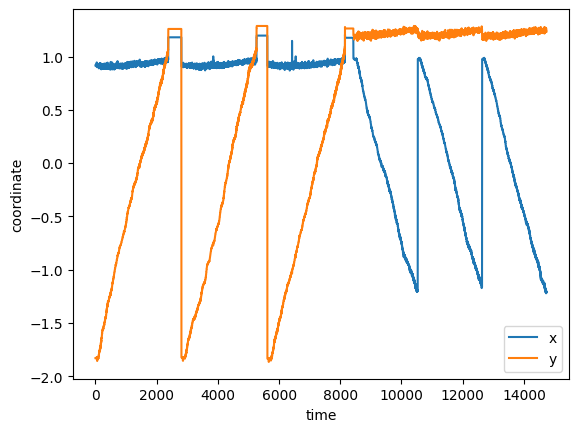

In [7]:
plt.plot(y_train[:,0], label='x')
plt.plot(y_train[:,1], label='y')
plt.ylabel('coordinate')
plt.xlabel('time')
plt.legend()
plt.show()

In [8]:
data_frames_abnormal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed_mel_spectrogram/abnormal_mel_spectrogram_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_abnormal.append(df)
    
combined_df = pd.concat(data_frames_abnormal, ignore_index=True)

x_columns_to_use = [f'mel_spectrogram_{i}' for i in range(128)]

x_test_abnormal = combined_df[x_columns_to_use].values

y_columns_to_use = ['x','y']
y_test_abnormal = combined_df[y_columns_to_use].values


data_frames_normal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed_mel_spectrogram/mel_spectrogram_coordinate{i*4+3}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_normal.append(df)
    
combined_df = pd.concat(data_frames_normal, ignore_index=True)

x_columns_to_use = [f'mel_spectrogram_{i}' for i in range(128)]

x_test_normal = combined_df[x_columns_to_use].values

y_columns_to_use = ['x','y']
y_test_normal = combined_df[y_columns_to_use].values

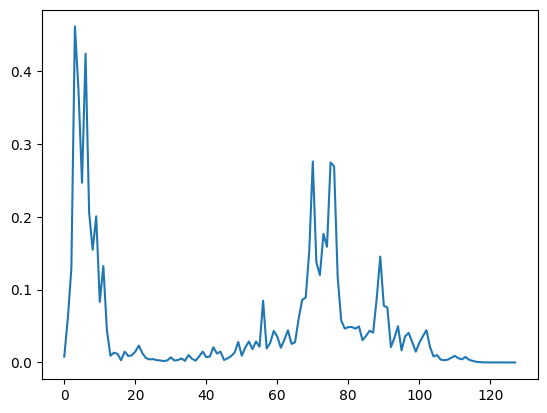

In [9]:
plt.plot(x_test_normal[3000])

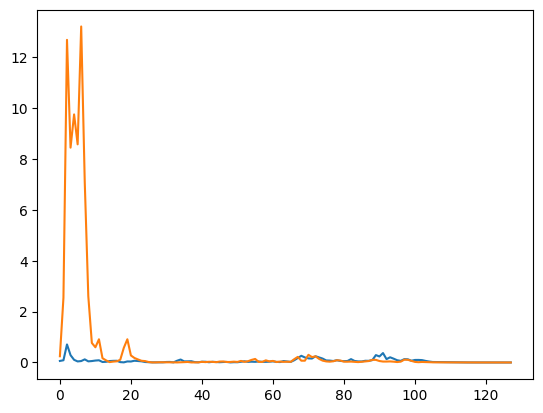

In [10]:
idx = 300
plt.plot(x_test_abnormal[idx])
plt.plot(x_test_normal[idx])

In [11]:
def min_max_scaler(arr,min_val,max_val):
    arr = (arr-min_val)/(max_val-min_val)   
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 1, 1, arr)
    return arr


std_weight = 3
for idx in range(y_train.shape[1]):
    mean_val = y_train[:,idx].mean()
    std_val = y_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    y_train[:,idx] = min_max_scaler(y_train[:,idx], min_val, max_val)
    y_test_abnormal[:,idx] = min_max_scaler(y_test_abnormal[:,idx], min_val, max_val)
    y_test_normal[:,idx] = min_max_scaler(y_test_normal[:,idx], min_val, max_val)

In [12]:
std_weight = 3
for idx in range(x_train.shape[1]):
    mean_val = x_train[:,idx].mean()
    std_val = x_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    x_train[:,idx] = min_max_scaler(x_train[:,idx], min_val, max_val)
    x_test_abnormal[:,idx] = min_max_scaler(x_test_abnormal[:,idx], min_val, max_val)
    x_test_normal[:,idx] = min_max_scaler(x_test_normal[:,idx], min_val, max_val)

In [13]:
WINDOW_LEN = 10

def transform_for_predictor_input(X_arr):
    X_train = []
    for time_idx in range(X_arr.shape[-1] - WINDOW_LEN):
        X_train.append(X_arr[:, time_idx:time_idx + WINDOW_LEN].T)
    return np.array(X_train)

def transform_predictor_output(y_arr):
    Y_train = []
    for time_idx in range(y_arr.shape[-1] - WINDOW_LEN):
        Y_train.append(y_arr[:, time_idx + WINDOW_LEN].T)
    return np.array(Y_train)

# RNNへの入力は3次元のテンソル[サンプル数, 時刻ステップ数，特徴量数]に変換する必要がある．
x_train = transform_for_predictor_input(x_train.T)
y_train = transform_predictor_output(y_train.T)

# sample_rate = 1
# indices = np.random.choice(range(x_train.shape[0]), int(x_train.shape[0]*sample_rate), replace=False)
# x_train = x_train[indices]
# y_train = y_train[indices]

# rnn_output_dim, dnn_output_dim = 64, 32
# predictor = Sequential()
# predictor.add(LSTM(rnn_output_dim, input_shape=(WINDOW_LEN, x_train.shape[-1])))
# predictor.add(Dropout(0.1))
# predictor.add(Dense(dnn_output_dim, activation=LeakyReLU(alpha=0.01)))
# predictor.add(Dropout(0.1))
# predictor.add(Dense(y_train.shape[-1],activation='sigmoid'))
# predictor.compile(optimizer='adam', loss='mse')

# early_stopping =  EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.0,
#     patience=10,
# )

# history = predictor.fit(
#     x_train,
#     y_train,
#     epochs=200,
#     batch_size=128,
#     verbose=2,
#     validation_split=1/5,
#     shuffle=True,
#     callbacks=[early_stopping] 
# )

In [14]:
x_test_normal = transform_for_predictor_input(x_test_normal.T)
x_test_abnormal = transform_for_predictor_input(x_test_abnormal.T)
y_test_abnormal = transform_predictor_output(y_test_abnormal.T)
y_test_normal = transform_predictor_output(y_test_normal.T) 

In [15]:
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
X_test_normal = x_test_normal.reshape(x_test_normal.shape[0], x_test_normal.shape[1]*x_test_normal.shape[2])
X_test_abnormal = x_test_abnormal.reshape(x_test_abnormal.shape[0], x_test_abnormal.shape[1]*x_test_abnormal.shape[2])

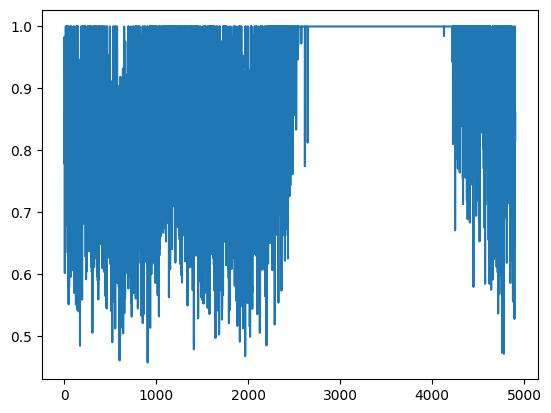

In [19]:
plt.plot(X_test_abnormal[:,1000])

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0

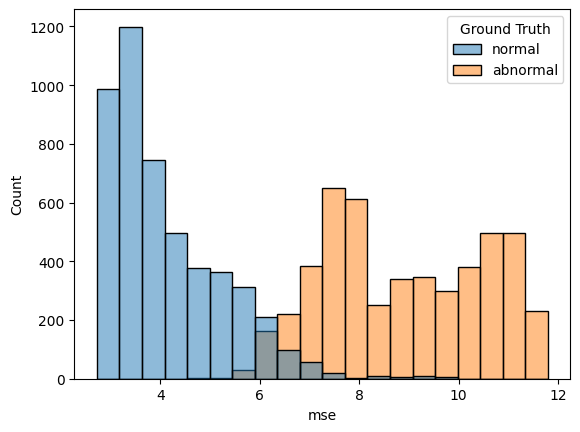

In [20]:
# オートエンコーダーのモデル作成・トレーニング用の関数
def create_and_train_autoencoder(X, encoding_dim=8, epochs=100):
    input_dim = X.shape[1]
    
    # モデルの定義
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # モデルのコンパイル
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # 学習
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=1024, shuffle=True, validation_data=(X_test, X_test))
    
    return autoencoder

model = create_and_train_autoencoder(X_train, encoding_dim = 10, epochs=20)

mse_abnormal =  np.sqrt(np.sum((model.predict(X_test_abnormal) - X_test_abnormal)**2, axis=1))
mse_normal = np.sqrt(np.sum((model.predict(X_test_normal) - X_test_normal)**2, axis=1))

plt_df_normal = pd.DataFrame({'mse':mse_normal})
plt_df_normal['Ground Truth'] = 'normal'
plt_df_abnormal = pd.DataFrame({'mse':mse_abnormal})
plt_df_abnormal['Ground Truth'] = 'abnormal'

plt_df = pd.concat([plt_df_normal, plt_df_abnormal], ignore_index=True)
sns.histplot(
    data=plt_df,
    x='mse',
    hue='Ground Truth'
)
plt_df['Label'] = plt_df['Ground Truth']=='abnormal'


# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['mse']).reshape(-1, 1)).flatten()

# AUC計算
auc = roc_auc_score(plt_df['Label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")


In [21]:
print(y_test_abnormal.shape)
print(x_test_abnormal.shape)

(4903, 2)
(4903, 10, 128)


In [22]:
mse_abnormal.shape

(4903,)

<Axes: >

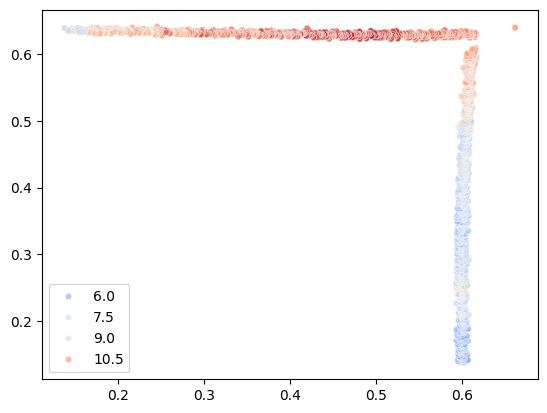

In [23]:
import seaborn as sns
sns.scatterplot(
    x=y_test_abnormal[:,0],
    y=y_test_abnormal[:,1],
    hue=mse_abnormal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

<Axes: >

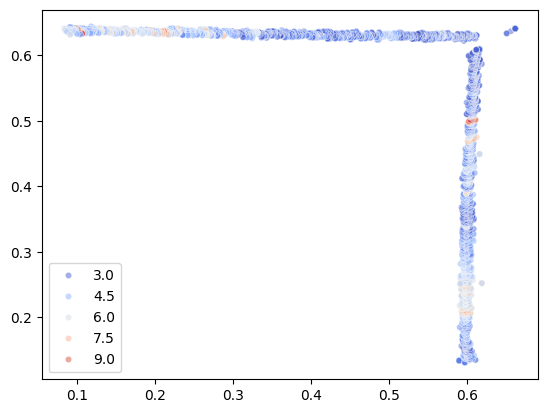

In [24]:
import seaborn as sns
sns.scatterplot(
    x=y_test_normal[:,0],
    y=y_test_normal[:,1],
    hue=mse_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

In [25]:
y_test_abnormal = y_test_abnormal[30:]
y_test_normal = y_test_normal[30:]

In [26]:
# 位置の予測と乖離の計算
pred_abnormal = predictor.predict(x_test_abnormal[30:])
pred_normal = predictor.predict(x_test_normal[30:])

# 予測と実際の位置の差を計算（乖離）
distances_abnormal = np.sqrt(np.sum((pred_abnormal - y_test_abnormal)**2, axis=1))
distances_normal = np.sqrt(np.sum((pred_normal - y_test_normal)**2, axis=1))

NameError: name 'predictor' is not defined

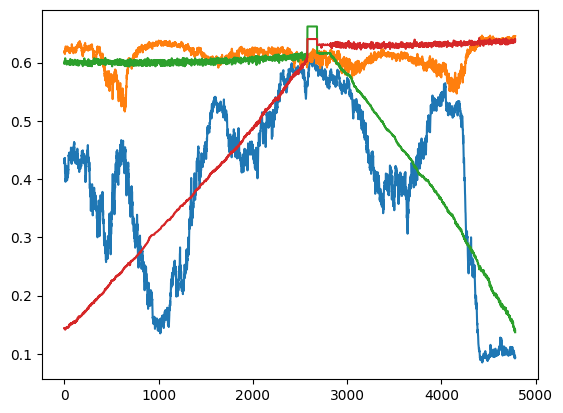

In [ ]:
plt.plot(pred_abnormal)
plt.plot(y_test_abnormal)

<Axes: >

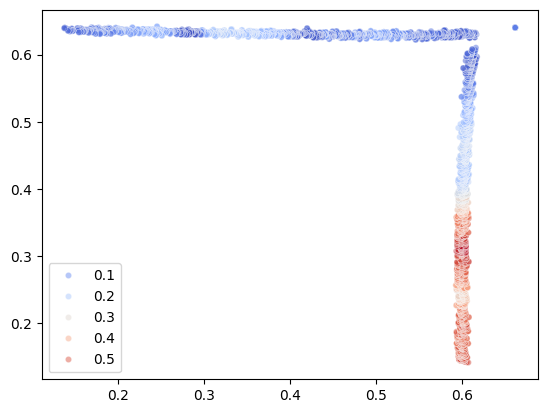

In [ ]:
import seaborn as sns
sns.scatterplot(
    x=y_test_abnormal[:,0],
    y=y_test_abnormal[:,1],
    hue=distances_abnormal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

<Axes: >

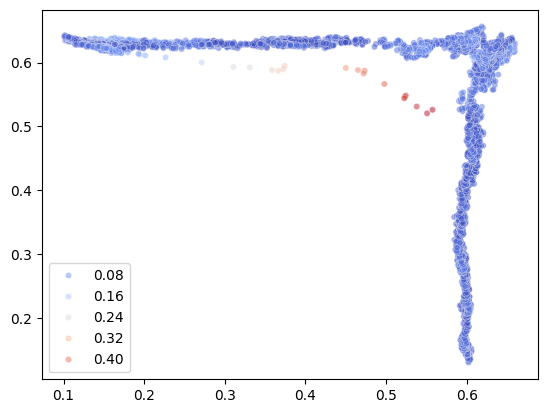

In [ ]:
import seaborn as sns
sns.scatterplot(
    x=pred_normal[:,0],
    y=pred_normal[:,1],
    hue=distances_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

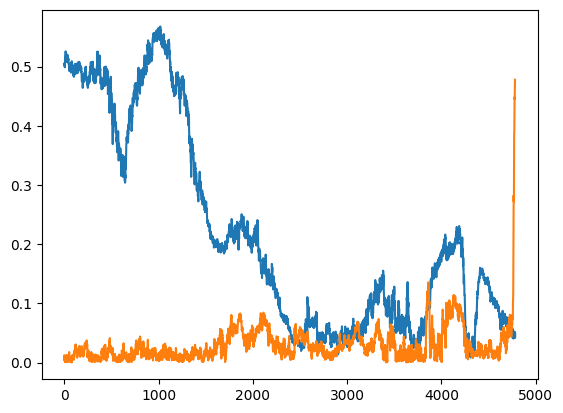

In [ ]:
plt.plot(distances_abnormal)
plt.plot(distances_normal)

<Axes: xlabel='mse', ylabel='Count'>

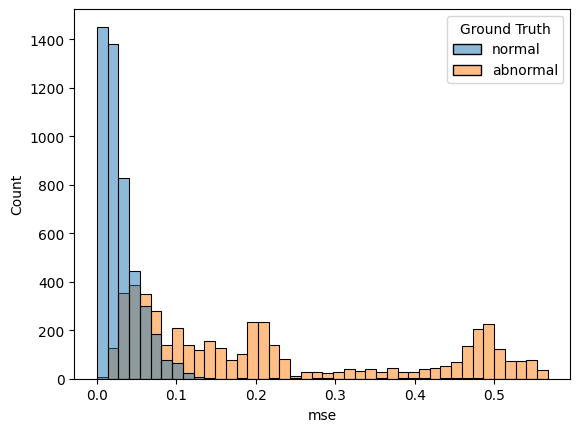

In [ ]:
plt_df_normal = pd.DataFrame({'mse':distances_normal})
plt_df_normal['Ground Truth'] = 'normal'
plt_df_abnormal = pd.DataFrame({'mse':distances_abnormal})
plt_df_abnormal['Ground Truth'] = 'abnormal'

plt_df = pd.concat([plt_df_normal, plt_df_abnormal], ignore_index=True)
sns.histplot(
    data=plt_df,
    x='mse',
    hue='Ground Truth'
)

In [ ]:
plt_df['Label'] = plt_df['Ground Truth']=='abnormal'
plt_df

,mse,Ground Truth,Label
0,0.011449,normal,False
1,0.006670,normal,False
2,0.004106,normal,False
3,0.012025,normal,False
4,0.003581,normal,False
...,...,...,...
9559,0.041246,abnormal,True
9560,0.041414,abnormal,True
9561,0.045222,abnormal,True
9562,0.050032,abnormal,True


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['mse']).reshape(-1, 1)).flatten()

# AUC計算
auc = roc_auc_score(plt_df['Label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")


AUC: 0.9351
